## Analysis of a dataset

This notebook shows example code used to calculate the assortativity coefficient for the dataset used in the supporting publication. The data is from:

> Stumpf, P. S., Smith, R. C. G., Lenz, M., Schuppert, A., Müller, F.-J., Babtie, A. C., Thalia, E. C., Stumpf, M. P. H., Please, C. P., Howison, S. D., Arai, F. and MacArthur, B. D. (2017). Stem cell differentiation as a non-Markov stochastic process. *Cell Systems*, 5(3), 268–282.  ([doi](https://doi.org/10.1016/j.cels.2017.08.009))


### Setup

Use packages, load the data and infer networks (including the GENIE3 network which was previously inferred using Python and made undirected by removing the second occurence of each pair of edges). Both correlation networks are unsigned.

In [1]:
using NetworkInference, Assortativity, Plots, Colors

In [2]:
datadir = "data/"
data_filename = "data.csv"
groups_filename = "groups.tsv"
nodes, expression_values = get_nodes(datadir * data_filename, delim = ',', get_values = true)
genes_to_groups = get_labels_to_groups(nodes, datadir * groups_filename)
groups_to_indices = get_groups_to_indices(genes_to_groups)
Pearson_net = InferredNetwork(CorrelationNetworkInference("Pearson", false, expression_values), nodes)
Spearman_net = InferredNetwork(CorrelationNetworkInference("Spearman", false, expression_values), nodes)
MI_net = InferredNetwork(MINetworkInference(), nodes)
CLR_net = InferredNetwork(CLRNetworkInference(), nodes)
PUC_net = InferredNetwork(PUCNetworkInference(), nodes)
PIDC_net = InferredNetwork(PIDCNetworkInference(), nodes)
GENIE3_net = load_network(datadir * "genie3.txt", ignoreotherline = false)
nets = [Pearson_net Spearman_net MI_net CLR_net PUC_net PIDC_net GENIE3_net]
algorithms = ["Pearson" "Spearman" "MI" "CLR" "PUC" "PIDC" "GENIE3"]
thresholds = (1:200) # edge thresholds to be plotted
colours = distinguishable_colors(length(algorithms), colorant"blue")

thread = 1 warning: only found 11 / 12 columns on data row: 19. Filling remaining columns with `missing`


Make a few helper function to easily plot the data.

In [3]:
make_layout(title) = plot(grid=true, foreground_color_grid=:black, gridalpha=0.3, xlims=(thresholds[1],thresholds[end]),
    ylims=(-0.4,1), xaxis="edge threshold", title=title)

make_layout (generic function with 1 method)

### 1. Degree assortativity

Regular then second neighbour degree assortativity.

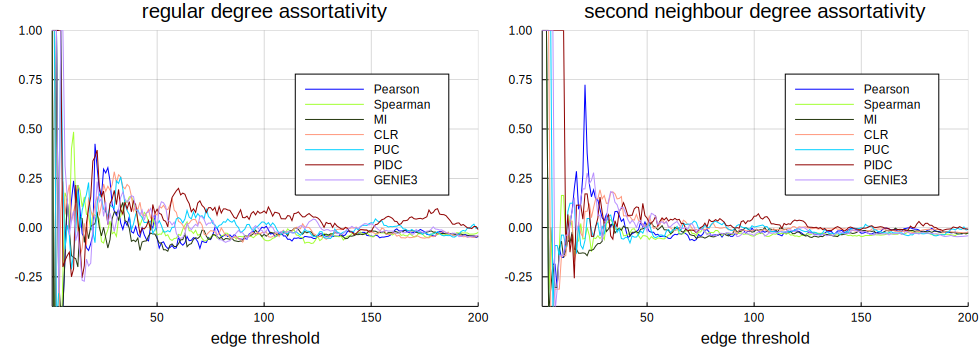

In [4]:
p1 = make_layout("regular degree assortativity"); [plot!(collect(thresholds),
        [a.value for a in assortativity(nets[i], thresholds)], lab=algorithms[i], color=colours[i]) for i in 1:length(nets)]
p2 = make_layout("second neighbour degree assortativity"); [plot!(collect(thresholds),
        [a.value for a in second_neighbour_assortativity(nets[i], thresholds)], lab=algorithms[i], color=colours[i]) for i in 1:length(nets)]
plot(p1, p2, size = (980,350))

### 2. Functional assortativity

Regular then second neighbour functional assortativity.

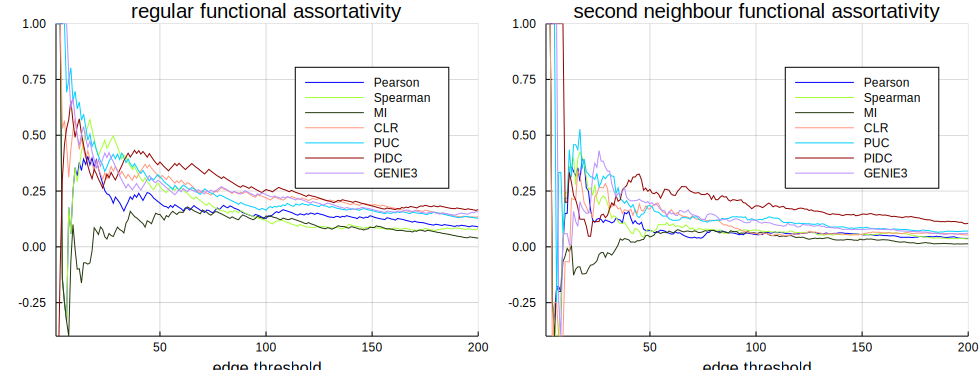

In [5]:
p1 = make_layout("regular functional assortativity"); [plot!(collect(thresholds),
        [a.value for a in assortativity(nets[i], genes_to_groups, groups_to_indices, thresholds)], lab=algorithms[i], color=colours[i]) for i in 1:length(nets)]
p2 = make_layout("second neighbour functional assortativity"); [plot!(collect(thresholds),
        [a.value for a in second_neighbour_assortativity(nets[i], genes_to_groups, groups_to_indices, thresholds)], lab=algorithms[i], color=colours[i]) for i in 1:length(nets)]
plot(p1, p2, size = (980,370))

### 3. Noise

Choose networks and number of iterations ⁠— both arbitrary and for the sake of making an example.

In [6]:
Spearman_net_150 = set_threshold(Spearman_net, 150)
CLR_net_150 = set_threshold(CLR_net, 150)
PIDC_net_150 = set_threshold(PIDC_net, 150)
noise_nets = [Spearman_net_150, CLR_net_150, PIDC_net_150]
noise_algorithms = ["Spearman", "CLR", "PIDC"]
iterations = 1000; println("number of random repeats = $(iterations)")

number of random repeats = 1000


#### 3.1 Network rewiring

Plotting 1000 values of functional assortativity in a Spearman, CLR and PIDC network where 50 or 100 edges are rewired.

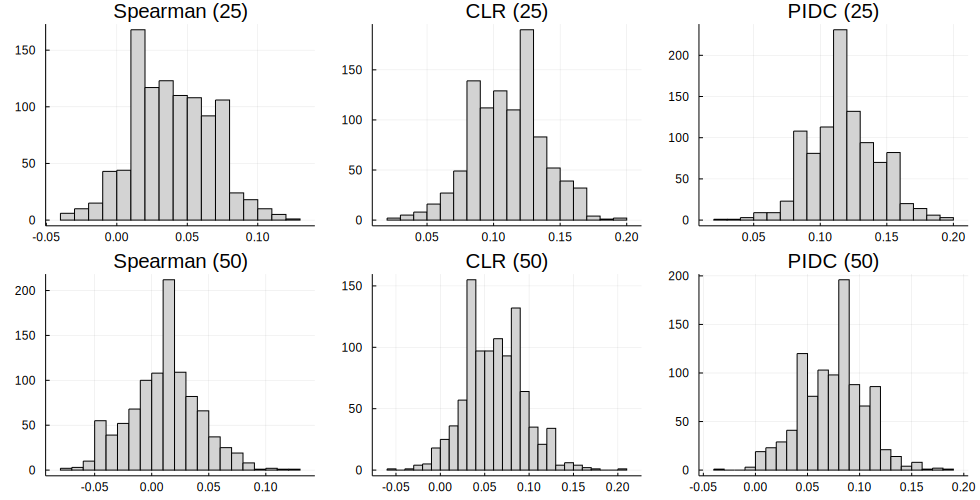

In [7]:
function get_rewired_assortativities(net, rand_level)
    assortativities = Vector{Float64}()
    for i in 1:iterations
        rewired_graph, rewired_ids_to_genes, rewired_edges = random_edge_rewiring(net, rand_level)
        push!(assortativities, assortativity(rewired_graph, genes_to_groups, groups_to_indices, rewired_ids_to_genes).value)
    end
    assortativities
end

h1 = histogram(get_rewired_assortativities(Spearman_net_150, 25), title="Spearman (25)", fillcolor=:lightgrey, leg=false)
h2 = histogram(get_rewired_assortativities(CLR_net_150, 25), title="CLR (25)", fillcolor=:lightgrey, leg=false)
h3 = histogram(get_rewired_assortativities(PIDC_net_150, 25), title="PIDC (25)", fillcolor=:lightgrey, leg=false)
h4 = histogram(get_rewired_assortativities(Spearman_net_150, 50), title="Spearman (50)", fillcolor=:lightgrey, leg=false)
h5 = histogram(get_rewired_assortativities(CLR_net_150, 50), title="CLR (50)", fillcolor=:lightgrey, leg=false)
h6 = histogram(get_rewired_assortativities(PIDC_net_150, 50), title="PIDC (50)", fillcolor=:lightgrey, leg=false)
plot(h1, h2, h3, h4, h5, h6, layout = (2,3), size = (980,500))

#### 3.2 Node deletion

Plotting 1000 values of functional assortativity in a Spearman, CLR and PIDC network where 10 or 30 nodes are deleted.

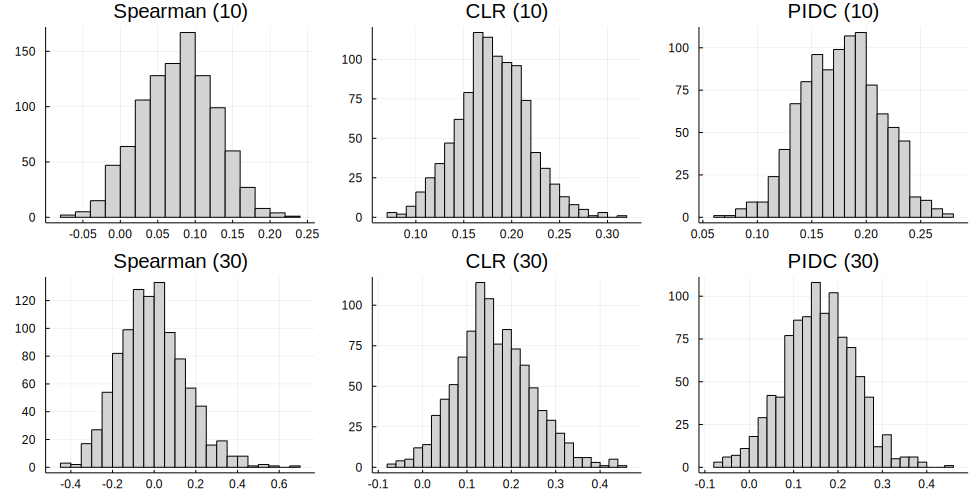

In [8]:
function get_node_deletion_assortativities(net, rand_level)
    assortativities = Vector{Float64}()
    for i in 1:iterations
        random_node_deletion_graph, random_node_deletion_ids_to_genes = random_node_deletion(net, rand_level)
        push!(assortativities, assortativity(random_node_deletion_graph, genes_to_groups, groups_to_indices, random_node_deletion_ids_to_genes).value)
    end
    assortativities
end

h1 = histogram(get_node_deletion_assortativities(Spearman_net_150, 10), title="Spearman (10)", fillcolor=:lightgrey, leg=false)
h2 = histogram(get_node_deletion_assortativities(CLR_net_150, 10), title="CLR (10)", fillcolor=:lightgrey, leg=false)
h3 = histogram(get_node_deletion_assortativities(PIDC_net_150, 10), title="PIDC (10)", fillcolor=:lightgrey, leg=false)
h4 = histogram(get_node_deletion_assortativities(Spearman_net_150, 30), title="Spearman (30)", fillcolor=:lightgrey, leg=false)
h5 = histogram(get_node_deletion_assortativities(CLR_net_150, 30), title="CLR (30)", fillcolor=:lightgrey, leg=false)
h6 = histogram(get_node_deletion_assortativities(PIDC_net_150, 30), title="PIDC (30)", fillcolor=:lightgrey, leg=false)
plot(h1, h2, h3, h4, h5, h6, layout = (2,3), size = (980,500))

#### 3.3 Random network

Plotting 1000 values of functional assortativity in a random Spearman, CLR and PIDC network.

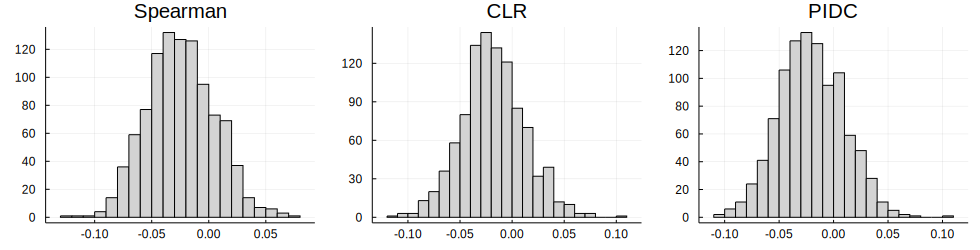

In [9]:
function get_random_net_assortativities(net)
    assortativities = Vector{Float64}()
    for i in 1:iterations
        random_graph, random_ids_to_genes = random_network(net)
        push!(assortativities, assortativity(random_graph, genes_to_groups, groups_to_indices, random_ids_to_genes).value)
    end
    assortativities
end

h1 = histogram(get_random_net_assortativities(Spearman_net_150), title="Spearman", fillcolor=:lightgrey, leg=false)
h2 = histogram(get_random_net_assortativities(CLR_net_150), title="CLR", fillcolor=:lightgrey, leg=false)
h3 = histogram(get_random_net_assortativities(PIDC_net_150), title="PIDC", fillcolor=:lightgrey, leg=false)
plot(h1, h2, h3, layout = (1,3), size = (980,250))

#### 3.4 Random annotations

Plotting 1000 values of functional assortativity in a Spearman, CLR and PIDC network with 10 or 50 randomised annotations.

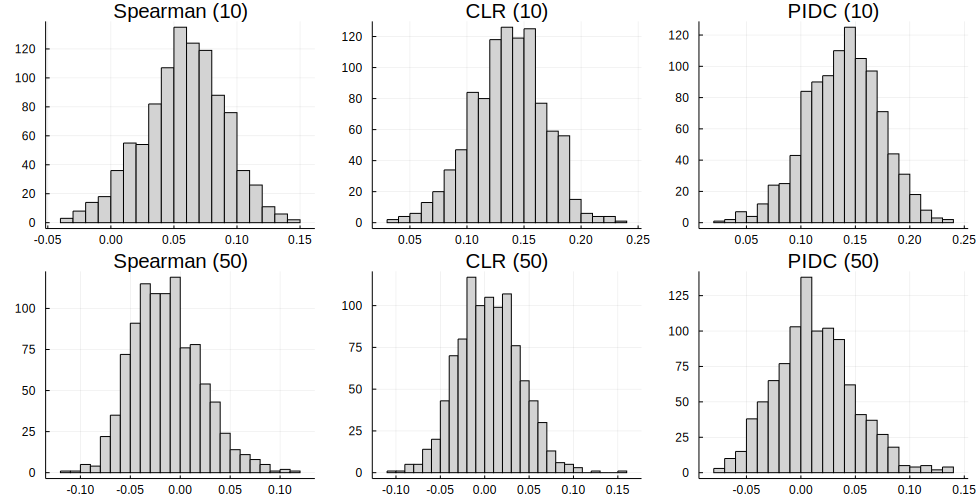

In [10]:
function get_random_annotations_assortativities(net, rand_level)
    assortativities = Vector{Float64}()
    for i in 1:iterations
        randomised_genes_to_groups = randomise_annotations(genes_to_groups, rand_level)[1]
        graph, new_ids_to_genes = InferredNetwork_to_LightGraph(net)
        push!(assortativities, assortativity(graph, randomised_genes_to_groups, groups_to_indices, new_ids_to_genes).value)
    end
    assortativities
end

h1 = histogram(get_random_annotations_assortativities(Spearman_net_150, 10), title="Spearman (10)", fillcolor=:lightgrey, leg=false)
h2 = histogram(get_random_annotations_assortativities(CLR_net_150, 10), title="CLR (10)", fillcolor=:lightgrey, leg=false)
h3 = histogram(get_random_annotations_assortativities(PIDC_net_150, 10), title="PIDC (10)", fillcolor=:lightgrey, leg=false)
h4 = histogram(get_random_annotations_assortativities(Spearman_net_150, 50), title="Spearman (50)", fillcolor=:lightgrey, leg=false)
h5 = histogram(get_random_annotations_assortativities(CLR_net_150, 50), title="CLR (50)", fillcolor=:lightgrey, leg=false)
h6 = histogram(get_random_annotations_assortativities(PIDC_net_150, 50), title="PIDC (50)", fillcolor=:lightgrey, leg=false)
plot(h1, h2, h3, h4, h5, h6, layout = (2,3), size = (980,500))